In [4]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import math
import numpy as np

In [5]:
df = pd.read_csv("C:/Users/Andrew/Downloads/jena_climate_2009_2016.csv")
del df['Date Time']

# This data contains time series weather attributes recorded by a weather station in Jena, Germany. 

# The goal of this exercise is to create a multi linear regression model that predicts/infers temperature based upon the other weather attributes. 

#I am eliminating the date column and assuming seasonality has minimal effect compared to the other x variables. This action is partially justified due to the fact that the R-squared & Adjusted R-Squared are already relatively high (0.998) with no seasonality factored in. 

#Below is some copy pasted code that outputs a list of correlation values between all columns in the data, sorted from highest correlation to lowest.
print("Data Frame")
print(df)
print()

print("Correlation Matrix")
print(df.corr())
print()

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 100))

Data Frame
          Pmbar  TdegC   TpotK  TdewdegC     RH  VPMAXmbar  VPACTmbar  \
0        996.52  -8.02  265.40     -8.90  93.30       3.33       3.11   
1        996.57  -8.41  265.01     -9.28  93.40       3.23       3.02   
2        996.53  -8.51  264.91     -9.31  93.90       3.21       3.01   
3        996.51  -8.31  265.12     -9.07  94.20       3.26       3.07   
4        996.51  -8.27  265.15     -9.04  94.10       3.27       3.08   
5        996.50  -8.05  265.38     -8.78  94.40       3.33       3.14   
6        996.50  -7.62  265.81     -8.30  94.80       3.44       3.26   
7        996.50  -7.62  265.81     -8.36  94.40       3.44       3.25   
8        996.50  -7.91  265.52     -8.73  93.80       3.36       3.15   
9        996.53  -8.43  264.99     -9.34  93.10       3.23       3.00   
10       996.62  -8.76  264.66     -9.66  93.10       3.14       2.93   
11       996.62  -8.88  264.54     -9.77  93.20       3.12       2.90   
12       996.63  -8.85  264.57     -9.70

                   Pmbar     TdegC     TpotK  TdewdegC        RH  VPMAXmbar  \
Pmbar           1.000000 -0.045375 -0.124718 -0.066755 -0.018352  -0.031546   
TdegC          -0.045375  1.000000  0.996827  0.895708 -0.572416   0.951113   
TpotK          -0.124718  0.996827  1.000000  0.894911 -0.567127   0.947293   
TdewdegC       -0.066755  0.895708  0.894911  1.000000 -0.156615   0.799271   
RH             -0.018352 -0.572416 -0.567127 -0.156615  1.000000  -0.615842   
VPMAXmbar      -0.031546  0.951113  0.947293  0.799271 -0.615842   1.000000   
VPACTmbar      -0.054370  0.867673  0.866205  0.968344 -0.151494   0.824865   
VPDEFmbar      -0.003401  0.761744  0.756962  0.435752 -0.843835   0.875588   
SHgPERkg       -0.069762  0.866755  0.866533  0.967599 -0.150841   0.824460   
H2OCmmolPERmol -0.069804  0.867177  0.866955  0.968044 -0.150969   0.824493   
RHOgPERm3       0.307640 -0.963410 -0.981345 -0.885232  0.514282  -0.901536   
WVmPERs        -0.005701 -0.004689 -0.004195 -0.0087

In [6]:
df.head()

,Pmbar,TdegC,TpotK,TdewdegC,RH,VPMAXmbar,VPACTmbar,VPDEFmbar,SHgPERkg,H2OCmmolPERmol,RHOgPERm3,WVmPERs,MAXWVmPERs,WDdeg
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [7]:
df.describe()

,Pmbar,TdegC,TpotK,TdewdegC,RH,VPMAXmbar,VPACTmbar,VPDEFmbar,SHgPERkg,H2OCmmolPERmol,RHOgPERm3,WVmPERs,MAXWVmPERs,WDdeg
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [4]:
df.corr().sort_values('TdegC', ascending=False)

,Pmbar,TdegC,TpotK,TdewdegC,RH,VPMAXmbar,VPACTmbar,VPDEFmbar,SHgPERkg,H2OCmmolPERmol,RHOgPERm3,WVmPERs,MAXWVmPERs,WDdeg
TdegC,-0.045375,1.000000,0.996827,0.895708,-0.572416,0.951113,0.867673,0.761744,0.866755,0.867177,-0.963410,-0.004689,-0.002871,0.038732
TpotK,-0.124718,0.996827,1.000000,0.894911,-0.567127,0.947293,0.866205,0.756962,0.866533,0.866955,-0.981345,-0.004195,-0.002224,0.043599
VPMAXmbar,-0.031546,0.951113,0.947293,0.799271,-0.615842,1.000000,0.824865,0.875588,0.824460,0.824493,-0.901536,-0.004018,-0.002213,-0.009583
TdewdegC,-0.066755,0.895708,0.894911,1.000000,-0.156615,0.799271,0.968344,0.435752,0.967599,0.968044,-0.885232,-0.008718,-0.009091,0.049877
VPACTmbar,-0.054370,0.867673,0.866205,0.968344,-0.151494,0.824865,1.000000,0.449154,0.999851,0.999856,-0.850241,-0.009600,-0.010316,0.018418
H2OCmmolPERmol,-0.069804,0.867177,0.866955,0.968044,-0.150969,0.824493,0.999856,0.448689,0.999997,1.000000,-0.853769,-0.009477,-0.010158,0.019607
SHgPERkg,-0.069762,0.866755,0.866533,0.967599,-0.150841,0.824460,0.999851,0.448641,1.000000,0.999997,-0.853325,-0.009479,-0.010163,0.019376
VPDEFmbar,-0.003401,0.761744,0.756962,0.435752,-0.843835,0.875588,0.449154,1.000000,0.448641,0.448689,-0.698290,0.001852,0.005317,-0.030881
WDdeg,-0.063258,0.038732,0.043599,0.049877,-0.015912,-0.009583,0.018418,-0.030881,0.019376,0.019607,-0.058072,-0.015322,-0.014471,1.000000
MAXWVmPERs,-0.007760,-0.002871,-0.002224,-0.009091,-0.009921,-0.002213,-0.010316,0.005317,-0.010163,-0.010158,0.001086,0.948477,1.000000,-0.014471


In [15]:
# Multi linear regression performed. TpotK removed as it almost perfectly correlates with TdegC, hence I am assuming it is simply the Kelvin measure of the temperature. The lack of a perfect 1 correlation may be due to measuring errors only. 

lm = smf.ols(formula='TdegC ~ TdewdegC + RH + VPMAXmbar + VPACTmbar + VPDEFmbar + SHgPERkg + H2OCmmolPERmol + RHOgPERm3 + WVmPERs + MAXWVmPERs + WDdeg', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TdegC   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.306e+07
Date:                Sun, 04 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:18:16   Log-Likelihood:            -1.6641e+05
No. Observations:              420551   AIC:                         3.328e+05
Df Residuals:                  420540   BIC:                         3.330e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         47.9184      0.138    347.740      0.000      47.648      48.188
TdewdegC           0.8892      0.001   1019.936      0.000       0.887       0.891
RH                -0.1442      0.000  -1244.298      0.000      -0.144      -0.144
VPACTmbar          3.5396      0.018    199.730      0.000       3.505       3.574
VPDEFmbar          0.2412      0.000    855.809      0.000       0.241       0.242
SHgPERkg          -2.0041      0.138    -14.492      0.000      -2.275      -1.733
H2OCmmolPERmol    -2.3066      0.088    -26.280      0.000      -2.479      -2.135
RHOgPERm3         -0.0266      0.000   -225.551      0.000      -0.027      -0.026
WVmPERs         2.946e-05   2.67e-05      1.102      0.270   -2.29e-05    8.19e-05
MAXWVmPERs     -1.519e-05   2.54e-05     -0.599      0.549   -6.49e-05    3.45e-05
WDdeg             -0.0002   6.52e-06    -23.616      0.000      -0.000      -0.000
==============================================================================
Omnibus:                   288775.868   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11776776.335
Skew:                           2.799   Prob(JB):                         0.00
Kurtosis:                      28.313   Cond. No.                     3.63e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
#WVmPERs and MAXWVmPERS removed due to lack of statistical significance as can be seen in the above summary. The regression was then rerun. As expected, there was no change in the R^2 or Adjusted R^2 values. All other variables seem highly significant.

lm = smf.ols(formula='TdegC ~ TdewdegC + RH + VPMAXmbar + VPACTmbar + VPDEFmbar + SHgPERkg + H2OCmmolPERmol + RHOgPERm3 + WDdeg', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TdegC   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.562e+07
Date:                Sun, 04 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:15:00   Log-Likelihood:            -1.6634e+05
No. Observations:              420551   AIC:                         3.327e+05
Df Residuals:                  420541   BIC:                         3.328e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         47.9932      0.138    347.950      0.000      47.723      48.264
TdewdegC           0.8888      0.001   1018.741      0.000       0.887       0.890
RH                -0.1441      0.000  -1242.978      0.000      -0.144      -0.144
VPMAXmbar          1.2741      0.111     11.518      0.000       1.057       1.491
VPACTmbar          2.2760      0.111     20.481      0.000       2.058       2.494
VPDEFmbar         -1.0329      0.111     -9.337      0.000      -1.250      -0.816
SHgPERkg          -2.0041      0.138    -14.494      0.000      -2.275      -1.733
H2OCmmolPERmol    -2.3167      0.088    -26.398      0.000      -2.489      -2.145
RHOgPERm3         -0.0266      0.000   -225.877      0.000      -0.027      -0.026
WDdeg             -0.0002   6.51e-06    -23.552      0.000      -0.000      -0.000
==============================================================================
Omnibus:                   288634.276   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11759814.803
Skew:                           2.798   Prob(JB):                         0.00
Kurtosis:                      28.294   Cond. No.                     4.25e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# Now removing variables until Adjusted R-squared begins to go down, in order to streamline the regression. Selected variables were removed through trial and error.

# VPMAXmbar, VPACTmbar, SHgPERkg, H2OCmmolPERmol, RHOgPERm3 and WDdeg were removed.

lm = smf.ols(formula='TdegC ~ TdewdegC + RH + VPDEFmbar', data=df).fit()
lm.summary()

# The following variables were determined to have the largest predictive impact on temperature (my interpretation of the meaning of the variables may be innacurate as no data dictionary was provided):
# 1. Temperature of Dew (Tdewdeg) (Or some form of precipitation measurement I assume)
# 2. Relative Humidity (RH)
# 3. Saturation Vapor Pressure Deficity (VPDEF) 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TdegC   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 6.184e+07
Date:                Sun, 04 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:34:16   Log-Likelihood:            -2.1201e+05
No. Observations:              420551   AIC:                         4.240e+05
Df Residuals:                  420547   BIC:                         4.241e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.3682      0.007   2434.540      0.000      16.355      16.381
TdewdegC       0.9781      0.000   8627.240      0.000       0.978       0.978
RH            -0.1680   7.77e-05  -2162.150      0.000      -0.168      -0.168
VPDEFmbar      0.2477      0.000    863.477      0.000       0.247       0.248
==============================================================================
Omnibus:                   274048.665   Durbin-Watson:                   0.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9856676.183
Skew:                           2.626   Prob(JB):                         0.00
Kurtosis:                      26.128   Cond. No.                         849.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

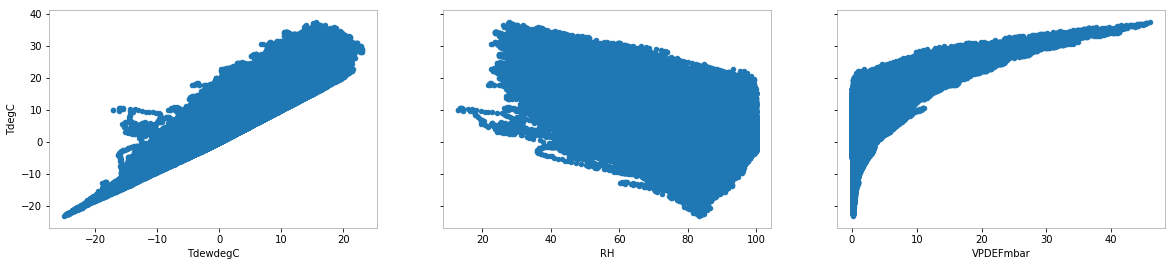

In [16]:
df = pd.read_csv("C:/Users/Andrew/Downloads/jena_climate_2009_2016.csv")
del df['Date Time']
fig,axs=plt.subplots(1,3,sharey=True)
df.plot(kind='scatter',x='TdewdegC',y='TdegC',ax=axs[0],figsize=(20,4)).set_facecolor("white")
df.plot(kind='scatter',x='RH',y='TdegC',ax=axs[1],figsize=(20,4)).set_facecolor("white")
df.plot(kind='scatter',x='VPDEFmbar',y='TdegC',ax=axs[2],figsize=(20,4)).set_facecolor("white")

#From the graphs plotted, some observations:
#1. TdewdegC shows signs of heteroskedasticity. Therefore, robust standard errors should be used when performing inference.
#2. VPDEFmbar appears to have a non-linear relationship with TdegC, testing a regression with the data transformed may be worthwhile. However, I recieved an overflow error while attempting to exponent all the VPDEFmbar values and thus this is yet to be tested.
#For the above point, the functional form of VPDEFmbar was unable to be determined. Exponating and squaring did not provide desirable results.

#Upon evaluating coefficients and looking at the below graphs, it was determined that RH negatively correlates with TdegC whereas the other x variables positively correlate.


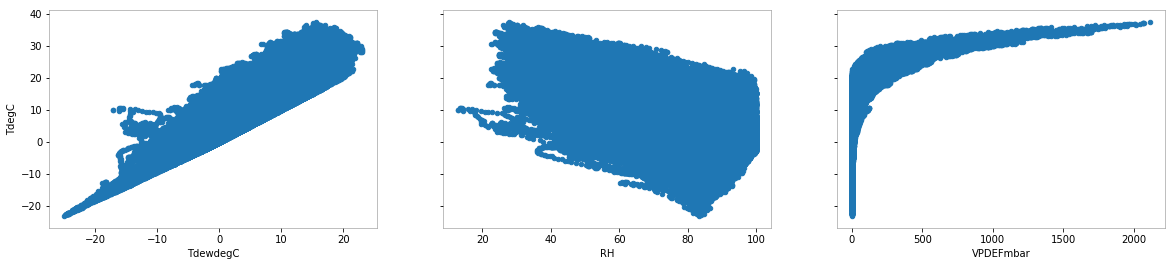

In [17]:
#Experimenting with squaring

df = pd.read_csv("C:/Users/Andrew/Downloads/jena_climate_2009_2016.csv")
del df['Date Time']
df['VPDEFmbar'] = np.square(df['VPDEFmbar'])
fig,axs=plt.subplots(1,3,sharey=True)
df.plot(kind='scatter',x='TdewdegC',y='TdegC',ax=axs[0],figsize=(20,4)).set_facecolor("white")
df.plot(kind='scatter',x='RH',y='TdegC',ax=axs[1],figsize=(20,4)).set_facecolor("white")
df.plot(kind='scatter',x='VPDEFmbar',y='TdegC',ax=axs[2],figsize=(20,4)).set_facecolor("white")

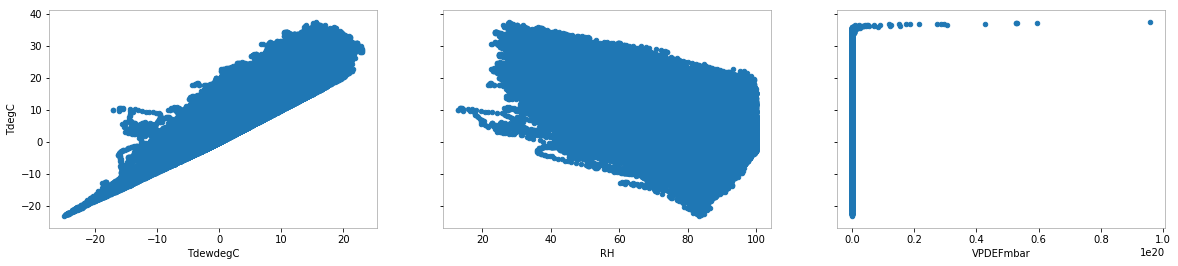

In [18]:
#Experimenting with exponating

df = pd.read_csv("C:/Users/Andrew/Downloads/jena_climate_2009_2016.csv")
del df['Date Time']
df['VPDEFmbar'] = np.exp(df['VPDEFmbar'])
fig,axs=plt.subplots(1,3,sharey=True)
df.plot(kind='scatter',x='TdewdegC',y='TdegC',ax=axs[0],figsize=(20,4)).set_facecolor("white")
df.plot(kind='scatter',x='RH',y='TdegC',ax=axs[1],figsize=(20,4)).set_facecolor("white")
df.plot(kind='scatter',x='VPDEFmbar',y='TdegC',ax=axs[2],figsize=(20,4)).set_facecolor("white")

In [19]:
#Performing inference based on dummy data and coefficients determined in the regression (non-transformed).

#The output of the print is the predicted temperature of a day given the following data: 
#Tdewdeg = 20 degrees
#RH = 60 %
#VPDEF = 0.4 mbar

y = 16.382 + 0.9781 * 20 -0.1680 * 60 + 0.2477 * 0.4
print("The temperature is approximately " + str(np.round(y)) + " degrees Celcius" )

#The accuracy of the model should be relatively high due to the low R-squared value. However, to assess its predictive accuracy, new data should be collected and fed into the model.

The temperature is approximately 26.0 degrees Celcius
